# Модель прогнозирования стоимости жилья для агентства недвижимости - ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ

Это дополнительная ветка исследования, где проверялась гипотеза о том, что плохие результаты на полном наборе данных связаны со слишком большим разбросом в данных, в частности:
- слишком длинный правый хвост в распределении целевой переменной, который я обрезал на уровне 1 млн. долларов;
- слишком длинный левый хвост в распределении признака года постройки, который я обрезал на уровне 1900 года.

Т.е. из всего очищенного датасета были исключены записи со стоимостью дороже 1 млн. долларов и старее 1900 года постройки.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from catboost import CatBoostRegressor
from ydata_profiling import ProfileReport
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [20]:
# загрузим наш очищенный датасет
df = pd.read_csv('data/data_preproc.csv')
df.head()

,status,propertyType,baths,fireplace,sqft,beds,stories,target,ZIP,LAT,...,heating,cooling,parking,lotsize,remodeling,lotsize_was_null,mean_school_rating,mean_school_distance,schools_count,beds_was_null
0,active,single-family,3.5,1,2900.0,4.0,1.0,418000.0,28387,35.179251,...,central,no data,no data,8276.0,0,1,5.2,5.5,8.0,0
1,for sale,single-family,3.0,0,1947.0,3.0,2.0,310000.0,99216,47.686363,...,no data,no data,no data,5828.0,0,0,4.0,1.3,3.0,0
2,for sale,single-family,8.0,1,6457.0,5.0,3.0,2395000.0,75205,32.835893,...,forced air,central,detached garage,8220.0,1,0,9.2,0.8,4.0,0
3,for sale,townhouse,3.0,0,897.0,2.0,2.0,209000.0,19145,39.909857,...,forced air,central,no data,680.0,0,0,1.4,0.4,2.0,0
4,active,other,2.0,0,1507.0,3.0,1.0,181500.0,34759,28.103908,...,electric,central,no data,4996.0,1,0,2.3,3.8,4.0,1


In [21]:
# ОЧИСТИМ ДАТАСЕТ ОТ ОБЪЕКТОВ, КОТОРЫЕ СТОЯТ ДОРОЖЕ 1 МЛН.ДОЛЛАРОВ И ПОСТРОЕНЫ ДО 1900 ГОДА
df = df[(df['target'] <= 1e6) & (df['year_built'] >= 1900)]

In [22]:
# посмотрим на наши обработанные данные
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="ИНФОРМАЦИЯ ОБ ОБЪЕКТАХ НЕДВИЖИМОСТИ")
profile.to_file("preprocessed_data_short.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Далее проведем всю ту же самую работу по моделированию, что и в основной ветке

In [23]:
df = pd.get_dummies(df, columns=['status', 'propertyType', 'cooling', 'heating', 'parking'], drop_first=True)

In [24]:
# Удаляем сильно скореллированные признаки 
df.drop(['ZIP', 'cooling_no data'], axis = 1, inplace = True)
# Еще раз выгрузим данные для модели в csv
df.to_csv('data/data_4_model_short.csv', index = False)

In [25]:
df = pd.read_csv('data/data_4_model_short.csv')
df.head()

,baths,fireplace,sqft,beds,stories,target,LAT,LNG,private_pool,year_built,...,parking_attached garage,parking_carport,parking_detached garage,parking_garage,parking_no data,parking_none,parking_off street,parking_on street,parking_other,parking_parking
0,3.5,1,2900.00,4.0,1.0,418000.0,35.179251,-79.376489,0,2019,...,False,False,False,False,True,False,False,False,False,False
1,3.0,0,1947.00,3.0,2.0,310000.0,47.686363,-117.216681,0,2019,...,False,False,False,False,True,False,False,False,False,False
2,3.0,0,897.00,2.0,2.0,209000.0,39.909857,-75.198265,0,1920,...,False,False,False,False,True,False,False,False,False,False
3,2.0,0,1507.00,3.0,1.0,181500.0,28.103908,-81.419378,0,2006,...,False,False,False,False,True,False,False,False,False,False
4,2.5,0,1192.98,3.0,1.0,68000.0,35.053329,-89.862806,0,1976,...,False,False,False,False,True,False,False,False,False,False


Теперь, когда все наши признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы за исключением целевого признака target и его логарифмированной версии target_log:

In [26]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помним, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

In [27]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# обучаем скейлер на тренировочной выборке
scaler.fit(X_train)

# трансформируем тренировочные и тестовые данные 
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

Cоздадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (базовая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [28]:
def print_metrics(model_name, y_train, y_train_predict, y_test, y_test_predict):
    train_r2 = metrics.r2_score(y_train, y_train_predict)
    train_mae = metrics.mean_absolute_error(y_train, y_train_predict)
    train_mape = metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100
    test_r2 = metrics.r2_score(y_test, y_test_predict)
    test_mae = metrics.mean_absolute_error(y_test, y_test_predict)
    test_mape = metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100
    print('Train R^2: {:.3f}'.format(train_r2))
    print('Train MAE: {:.3f}'.format(train_mae))
    print('Train MAPE: {:.3f}%'.format(train_mape))
    print('\n')
    print('Test R^2: {:.3f}'.format(test_r2))
    print('Test MAE: {:.3f}'.format(test_mae))
    print('Test MAPE: {:.3f}%'.format(test_mape))
    return [model_name, 
            round(train_r2, 2),
            round(train_mae, 2),
            round(train_mape, 2),
            round(test_r2, 2), 
            round(test_mae, 2), 
            round(test_mape, 2)
            ]

## Линейная регрессия

Первым делом сформируем базовую модель на всех признаках, после стандартизации их получилось 63. Далее производим предсказание на тренировочной и тестовых данных и считаем метрики.

In [29]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scal, y_train)
#Делаем предсказание для каждой из выборок
y_train_predict = lr.predict(X_train_scal)
y_test_predict = lr.predict(X_test_scal)
#Выводим результирующие метрики
s1 = print_metrics('LR full', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.354
Train MAE: 129750.193
Train MAPE: 48.876%


Test R^2: 0.362
Test MAE: 129000.519
Test MAPE: 49.058%


На первой же, самой неэффективной модели, получаем результаты лучше!\
Напомню, что на "необрезанном" наборе данных Test MAE был более 207 тыс, а Test MAPE - почти 62%\
НО! Коэффициент детерминации стал хуже (ранее был 0.42), т.е. степень соответствия модели реальным данным никуда не годится.\
Посмотрим метрики на остальных моделях.

Попробуем метод на основе фильтров. Обучим модель на 25 отобранных признаках - для этого используем SelectKBest.

In [30]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train_scal, y_train)
best_features = selector.get_feature_names_out()
best_features

array(['baths', 'fireplace', 'sqft', 'beds', 'stories', 'LAT', 'LNG',
       'private_pool', 'year_built', 'mean_school_rating',
       'schools_count', 'status_foreclosed', 'status_new construction',
       'status_pending', 'propertyType_mobile home',
       'propertyType_multi-family', 'cooling_central', 'heating_electric',
       'heating_no data', 'parking_3 spaces', 'parking_4 spaces',
       'parking_5+ spaces', 'parking_attached garage', 'parking_carport',
       'parking_no data'], dtype=object)

Построим модель линейной регрессии на топ-25 отобранных признаках.

In [31]:
lr_2 = LinearRegression()
lr_2.fit(X_train_scal[best_features], y_train)
y_train_predict = lr_2.predict(X_train_scal[best_features])
y_test_predict = lr_2.predict(X_test_scal[best_features])

s2 = print_metrics('LR top25', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.324
Train MAE: 133251.027
Train MAPE: 50.527%


Test R^2: 0.334
Test MAE: 132291.726
Test MAPE: 50.614%


Метрики лучше не стали. Попробуем полиномиальную регрессию

## Полиномиальная регрессия

In [32]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scal[best_features])
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scal[best_features])
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scal[best_features])

print(X_train_poly.shape)
print(X_test_poly.shape)
print('\n')

#Создаём объект класса линейной регрессии
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model_poly.predict(X_test_poly)

s3 = print_metrics('PR top25', y_train, y_train_predict, y_test, y_test_predict)

(215961, 350)
(53991, 350)


Train R^2: 0.508
Train MAE: 112013.868
Train MAPE: 39.904%


Test R^2: 0.515
Test MAE: 110858.567
Test MAPE: 39.861%


Метрики улучшились, но такая модель по прежнему малопригодна для применения.

Построим модель полиномиальной регрессии второй степени с $L_1$-регуляризацией

In [33]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr = linear_model.Lasso(alpha=0.1)
lasso_lr.fit(X_train_poly, y_train)
y_train_predict = lasso_lr.predict(X_train_poly)
y_test_predict = lasso_lr.predict(X_test_poly)

s4 = print_metrics('L1 Lasso', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.508
Train MAE: 112011.249
Train MAPE: 39.889%


Test R^2: 0.514
Test MAE: 110862.547
Test MAPE: 39.850%


Построим модель полиномиальной регрессии второй степени с $L_2$-регуляризацией

In [34]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=0.1)
ridge_lr.fit(X_train_poly, y_train)
y_train_predict = ridge_lr.predict(X_train_poly)
y_test_predict = ridge_lr.predict(X_test_poly)

s5 = print_metrics('L2 Ridge', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.508
Train MAE: 112126.202
Train MAPE: 39.947%


Test R^2: 0.514
Test MAE: 110989.124
Test MAPE: 39.908%


Метрики остались на том же уровне. Теперь попробуем деревья решений.


## Деревья решений

Построим модель **DecisionTreeRegressor** на всех признаках, не ограничивая глубину деревьев

In [35]:
model_tree = tree.DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train_scal[best_features], y_train)

y_train_predict = model_tree.predict(X_train_scal[best_features])
y_test_predict = model_tree.predict(X_test_scal[best_features])

s6 = print_metrics('DT top25', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.999
Train MAE: 573.350
Train MAPE: 0.177%


Test R^2: 0.693
Test MAE: 67900.293
Test MAPE: 21.830%


Как видим, метрики на тестовой выборке значительно хуже, чем на тренировочной. Это значит, что модель сильно подстроилась под тренировочные данные и мы получили переобучение модели.  

In [36]:
# подберём оптимальные параметры глубины дерева
max_depths = range(5, 20)

def tree_depths(X_train, X_test, y_train, y_test):
  R_2_train = []
  R_2_test = []
  for depth in max_depths:
    model_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train, y_train)
    y_train_predict = model_tree.predict(X_train)
    y_test_predict = model_tree.predict(X_test)
    R_2_tr = round(metrics.r2_score(y_train, y_train_predict), 2)
    R_2_tes = round(metrics.r2_score(y_test, y_test_predict), 2)
    R_2_train.append(R_2_tr)
    R_2_test.append(R_2_tes)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_train, name='Train'))
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_test, name='Test'))
  fig.update_xaxes(title='Глубина дерева')
  fig.update_yaxes(title='Метрика R2')
  fig.update_layout(title='Зависимость метрики R2 от глубины дерева', height=800, width=800)
  return fig.show()

tree_depths(X_train_scal, X_test_scal, y_train, y_test)

Тут можно взять 11 глубину деревьев и построить модель

In [37]:
model_tree = tree.DecisionTreeRegressor(random_state=42, max_depth=11)
model_tree.fit(X_train_scal[best_features], y_train)

y_train_predict = model_tree.predict(X_train_scal[best_features])
y_test_predict = model_tree.predict(X_test_scal[best_features])

s7 = print_metrics('DT depth-10', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.676
Train MAE: 87075.771
Train MAPE: 30.914%


Test R^2: 0.650
Test MAE: 90287.721
Test MAPE: 31.942%


Метрики существенно улучшились

## Ансамблевые методы

Первой ансамблевой моделью будет **бэггинг** и его разновидность - модель случайного леса.

In [38]:
# бэггинг случайный лес
random_forest = ensemble.RandomForestRegressor(n_estimators=100,
                                               max_depth=11,
                                               min_samples_split = 20,                    
                                               random_state=42)

random_forest.fit(X_train_scal[best_features], y_train)

y_train_predict = random_forest.predict(X_train_scal[best_features])
y_test_predict = random_forest.predict(X_test_scal[best_features])

s8 = print_metrics('RFR', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.708
Train MAE: 83125.834
Train MAPE: 29.918%


Test R^2: 0.689
Test MAE: 85465.743
Test MAPE: 30.785%


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

Далее реализуем модель адаптивного бустинга **AdaBoost**

In [39]:
# бустинг
dt = tree.DecisionTreeRegressor(
    max_depth=11, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt,
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель
ada.fit(X_train_scal[best_features], y_train)

y_train_predict  = ada.predict(X_train_scal[best_features])
y_test_predict = ada.predict(X_test_scal[best_features])

s9 = print_metrics('AdaBoost', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.702
Train MAE: 83611.881
Train MAPE: 30.029%


Test R^2: 0.681
Test MAE: 86510.299
Test MAPE: 31.033%


Практически не получили улучшения качества метрик.

Также построим модель градиентного бустинга над деревьями решений **GBDT**

In [40]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=11, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.01 
)

# Обучаем модель
gb.fit(X_train_scal[best_features], y_train)

y_train_predict  = gb.predict(X_train_scal[best_features])
y_test_predict = gb.predict(X_test_scal[best_features])

s10 = print_metrics('GBDT', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.827
Train MAE: 63489.742
Train MAPE: 23.294%


Test R^2: 0.786
Test MAE: 69399.372
Test MAPE: 25.133%


Ну и последний из ансамблевых методов - **стекинг**. Сделаем сначала на простых моделях.

In [41]:
# Создаем список базовых моделей
estimators = [
    ('dt', tree.DecisionTreeRegressor(random_state=42, max_depth=11)),
    ('r',  RidgeCV())
]
# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators, # Передаем список базовых моделей
    final_estimator=ensemble.RandomForestRegressor(n_estimators=100,
                                               max_depth=11,
                                               min_samples_split = 20,             
                                               random_state=42) # В качестве метамодели используем RFR
)
# Обучаем модель
reg.fit(X_train_scal[best_features], y_train)

# Делаем предсказание классов с помощью метода predict(), а затем считаем метрики:
y_train_predict  = reg.predict(X_train_scal[best_features])
y_test_predict = reg.predict(X_test_scal[best_features])

s11 = print_metrics('Stacking', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.680
Train MAE: 87280.009
Train MAPE: 31.011%


Test R^2: 0.657
Test MAE: 89925.112
Test MAPE: 31.964%


## CatBoost

In [42]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[best_features], y_train)

y_train_predict  = catmodel.predict(X_train_scal[best_features])
y_test_predict = catmodel.predict(X_test_scal[best_features])

s12 = print_metrics('CatBoost top25', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.804
Train MAE: 65496.327
Train MAPE: 21.685%


Test R^2: 0.795
Test MAE: 66945.593
Test MAPE: 22.285%


По сравенению со всеми предыдущими моделями это лучший результат. Попробуем построить эту же модель на всех предикторах.

In [43]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

y_train_predict  = catmodel.predict(X_train_scal)
y_test_predict = catmodel.predict(X_test_scal)

s13 = print_metrics('CatBoost full',y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.817
Train MAE: 63431.126
Train MAPE: 20.982%


Test R^2: 0.807
Test MAE: 65037.299
Test MAPE: 21.658%


Получили еще немного улучшение. Проверим какие предикторы лучше всего подходят для этой модели

In [44]:
# признаки и их веса вносимые в модель
best_feature_cat = pd.DataFrame({'feature_importance': catmodel.get_feature_importance(), 
              'feature_names':X_train_scal.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
# топ-10 признаков по весам
new_best = best_feature_cat['feature_names'].iloc[:10]
best_feature_cat[:10]

,feature_importance,feature_names
6,33.249314,LNG
5,19.661002,LAT
2,18.968460,sqft
8,6.587667,year_built
12,5.301526,mean_school_rating
4,3.021015,stories
0,2.736209,baths
9,2.682709,lotsize
13,1.326450,mean_school_distance
3,0.950753,beds


Всё закономерно, как и в реальной жизни :-) на стоимость влияют такие параметры как местоположение, площадь дома, новизна дома, количество спален, ванных, этажность, размер участка, а также рейтинг и близость школ поблизости!

In [45]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[new_best], y_train)

y_train_predict  = catmodel.predict(X_train_scal[new_best])
y_test_predict = catmodel.predict(X_test_scal[new_best])

s14 = print_metrics('CatBoost top10', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.807
Train MAE: 65401.240
Train MAPE: 22.062%


Test R^2: 0.797
Test MAE: 66840.645
Test MAPE: 22.667%


## XGBoost

In [46]:
xgbmodel = xgb.XGBRegressor(random_state=42)
xgbmodel.fit(X_train_scal[new_best], y_train)
y_train_predict  = xgbmodel.predict(X_train_scal[new_best])
y_test_predict = xgbmodel.predict(X_test_scal[new_best])

s15 = print_metrics('XGBoost top10',y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.815
Train MAE: 64444.090
Train MAPE: 21.767%


Test R^2: 0.796
Test MAE: 67128.551
Test MAPE: 22.745%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

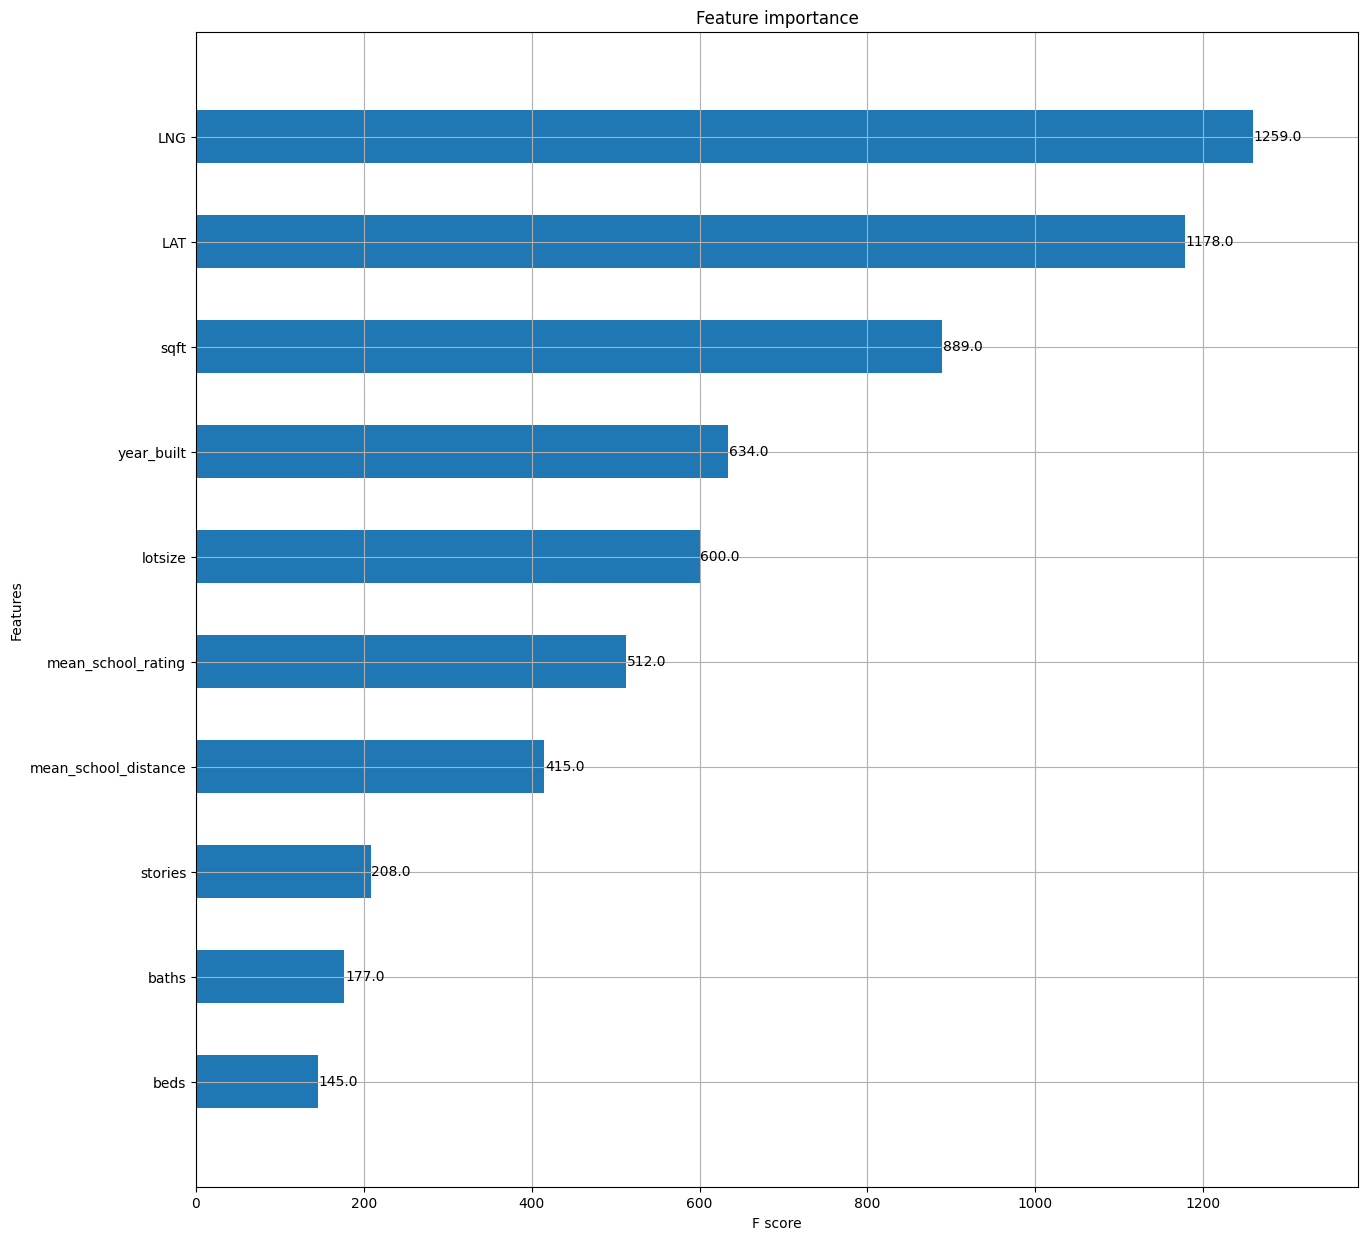

In [47]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xgbmodel, ax = ax, height=0.5)

Если не смотреть на CatBoost и XGBoost, то лучшие результаты до этого показал градиентный бустинг над деревьями решений (GBDT) на 25 предикторах. Попробуем теперь обучить ее на лучших 10 предикторах, которые мы определили для CatBoost.

In [48]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=11, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.01 
)

# Обучаем модель
gb.fit(X_train_scal[new_best], y_train)

y_train_predict  = gb.predict(X_train_scal[new_best])
y_test_predict = gb.predict(X_test_scal[new_best])

s16 = print_metrics('GBDT top10', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.839
Train MAE: 61501.275
Train MAPE: 22.991%


Test R^2: 0.794
Test MAE: 68075.815
Test MAPE: 25.011%


Что интересно, одна и та же модель на 10 признаках отработала чуть лучше, чем на полном наборе.

Теперь попробуем проапгрейдить модель стекинга. Обучим её на наших 10 лучших предикторах, а в качестве базовых моделей возьмём 4 различных моделей, которые мы ранее использовали:
- GradientBoostingRegressor;
- CatBoostRegressor;
- DecisionTreeRegressor;
- RidgeCV.

В качестве метамодели используем XGBoost. 

In [49]:
# Создаем список базовых моделей
estimators = [
    ('gbdt', GradientBoostingRegressor(
                                            max_depth=11, #максимальная глубина дерева
                                            n_estimators=300, #количество деревьев в ансамбле
                                            random_state=42, #генератор случайных чисел
                                            learning_rate=0.01 )),
    ('cat',  CatBoostRegressor(random_state=42, verbose=False)), 
    ('dt', tree.DecisionTreeRegressor(random_state=42, max_depth=11)),
    ('r', RidgeCV())
]
# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators, # Передаем список базовых моделей
    final_estimator=xgb.XGBRegressor()# В качестве метамодели используем xgb
)
# Обучаем модель
reg.fit(X_train_scal[new_best], y_train)

# Делаем предсказание классов с помощью метода predict(), а затем считаем метрики:
y_train_predict  = reg.predict(X_train_scal[new_best])
y_test_predict = reg.predict(X_test_scal[new_best])

s17 = print_metrics('Stacking GBDT+cat+dt+RidgeCV > xgb', y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.862
Train MAE: 55317.991
Train MAPE: 18.932%


Test R^2: 0.819
Test MAE: 61840.627
Test MAPE: 20.792%


## Подбор гиперпараметров

Теперь оценим ряд моделей с подбором гипермараметров. Будем использовать:
+ GridSearchCV для DecisionTreeRegressor
+ RandomizedSearchCV для GradientBoostingRegressor
+ Optuna для XGBRegressor

#### GridSearchCV для DecisionTreeRegressor

In [50]:
param_grid = {'min_samples_leaf': list(np.linspace(1, 100, 50, dtype=int)),
              'max_depth': [10, 11]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  

grid_search_tree.fit(X_train_scal[best_features], y_train) 

y_train_predict = grid_search_tree.predict(X_train_scal[best_features])
y_test_predict = grid_search_tree.predict(X_test_scal[best_features])

s18 = print_metrics('DT+GridSearchCV', y_train, y_train_predict, y_test, y_test_predict)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Train R^2: 0.673
Train MAE: 87731.106
Train MAPE: 31.091%


Test R^2: 0.654
Test MAE: 90056.300
Test MAPE: 31.894%
Наилучшие значения гиперпараметров: {'max_depth': 11, 'min_samples_leaf': 9}


#### RandomizedSearchCV для GradientBoostingRegressor

In [55]:
param_distributions = {'n_estimators': [200, 300],
              'learning_rate': [0.01, 0.1]
              }
            
random_search_GB = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42, max_depth=11), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
random_search_GB.fit(X_train_scal[best_features], y_train) 

y_train_predict = random_search_GB.predict(X_train_scal[best_features])
y_test_predict = random_search_GB.predict(X_test_scal[best_features])

s19 = print_metrics('GBDT top10 + RandomizedSearchCV', y_train, y_train_predict, y_test, y_test_predict)
print("Наилучшие значения гиперпараметров: {}".format(random_search_GB.best_params_))

Train R^2: 0.950
Train MAE: 33506.433
Train MAPE: 11.649%


Test R^2: 0.859
Test MAE: 52776.609
Test MAPE: 17.368%
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'learning_rate': 0.1}


#### Optuna для XGBRegressor

In [51]:
import optuna
# настроим оптимизацию гиперпараметров для алгоритма XGBoost
def optuna_xgb(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 9, 11),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'random_state': trial.suggest_int('random_state', 42, 42)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_scal[best_features], y_train)

    y_test_predict = model.predict(X_test_scal[best_features])

    test_mae = metrics.mean_absolute_error(y_test, y_test_predict)

    return test_mae

study = optuna.create_study(direction='minimize')
study.optimize(optuna_xgb, n_trials=100)

[I 2024-11-26 20:05:39,016] A new study created in memory with name: no-name-067d2c97-6ac1-4e7b-b487-3879d5622850
[I 2024-11-26 20:05:41,947] Trial 0 finished with value: 78275.76356076797 and parameters: {'learning_rate': 0.9492228556375347, 'max_depth': 9, 'subsample': 0.607671936391289, 'colsample_bytree': 0.9682339595715979, 'random_state': 42}. Best is trial 0 with value: 78275.76356076797.
[I 2024-11-26 20:05:45,651] Trial 1 finished with value: 154385.64549415643 and parameters: {'learning_rate': 0.001867751347872329, 'max_depth': 10, 'subsample': 0.8853240692858165, 'colsample_bytree': 0.6641809635906688, 'random_state': 42}. Best is trial 0 with value: 78275.76356076797.
[I 2024-11-26 20:05:50,748] Trial 2 finished with value: 169375.8182694801 and parameters: {'learning_rate': 2.6059390443724717e-05, 'max_depth': 11, 'subsample': 0.9072145456463863, 'colsample_bytree': 0.8910473638958112, 'random_state': 42}. Best is trial 0 with value: 78275.76356076797.
[I 2024-11-26 20:05:

In [52]:
# строим модель на лучших подобранных параметрах
param = study.best_params
xgbmodel = xgb.XGBRegressor(**param)
xgbmodel.fit(X_train_scal[new_best], y_train)
y_train_predict  = xgbmodel.predict(X_train_scal[new_best])
y_test_predict = xgbmodel.predict(X_test_scal[new_best])

s20 = print_metrics('XGBoost top10 + Optuna',y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.943
Train MAE: 36030.835
Train MAPE: 12.769%


Test R^2: 0.852
Test MAE: 54910.777
Test MAPE: 18.507%


# Оценка моделей

Создадим сводную таблицу по метрикам на обученных моделях.

In [56]:
res_df = pd.DataFrame(
    data = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, s15, s16, s17, s18, s19, s20],
    columns= ['Model', 
              'Train R2_v2', 'Train MAE_v2', 'Train MAPE_v2', 
              'Test R2_v2', 'Test MAE_v2', 'Test MAPE_v2']
)
display(res_df)

,Model,Train R2_v2,Train MAE_v2,Train MAPE_v2,Test R2_v2,Test MAE_v2,Test MAPE_v2
0,LR full,0.35,129750.19,48.88,0.36,129000.52,49.06
1,LR top25,0.32,133251.03,50.53,0.33,132291.73,50.61
2,PR top25,0.51,112013.87,39.90,0.51,110858.57,39.86
3,L1 Lasso,0.51,112011.25,39.89,0.51,110862.55,39.85
4,L2 Ridge,0.51,112126.20,39.95,0.51,110989.12,39.91
5,DT top25,1.00,573.35,0.18,0.69,67900.29,21.83
6,DT depth-10,0.68,87075.77,30.91,0.65,90287.72,31.94
7,RFR,0.71,83125.83,29.92,0.69,85465.74,30.79
8,AdaBoost,0.70,83611.88,30.03,0.68,86510.30,31.03
9,GBDT,0.83,63489.74,23.29,0.79,69399.37,25.13


In [57]:
# Выгрузим результат в отдельный файл:
res_df.to_csv('data/models_results_short.csv', index = False)

### Выводы представлены в основном файле [diplom_main_2.ipynb](https://github.com/veshua/diplom_sf/blob/main/diplom_main_2.ipynb)